## Required library

In [15]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from tensorflow.keras import layers
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from tensorflow.keras import Input
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.8.2


## Dataset download

In [16]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip \
    -O /tmp/fcnn-dataset.zip

# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = r'/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(r'/tmp/fcnn')
zip_ref.close()

--2022-07-16 05:20:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125577577 (120M) [application/zip]
Saving to: ‘/tmp/fcnn-dataset.zip’

/tmp/fcnn-dataset.z 100%[===================>] 119.76M  34.3MB/s    in 3.5s    

2022-07-16 05:20:30 (34.3 MB/s) - ‘/tmp/fcnn-dataset.zip’ saved [125577577/125577577]



## Processing dataset

In [17]:

# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']


In [18]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=512, width=512):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [19]:
# show folders inside the dataset you downloaded
!ls /tmp/fcnn/dataset1

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


In [20]:
# Utilities for preparing the datasets

BATCH_SIZE = 4

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset


In [21]:
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_train/','/tmp/fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_test/','/tmp/fcnn/dataset1/annotations_prepped_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [22]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [23]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

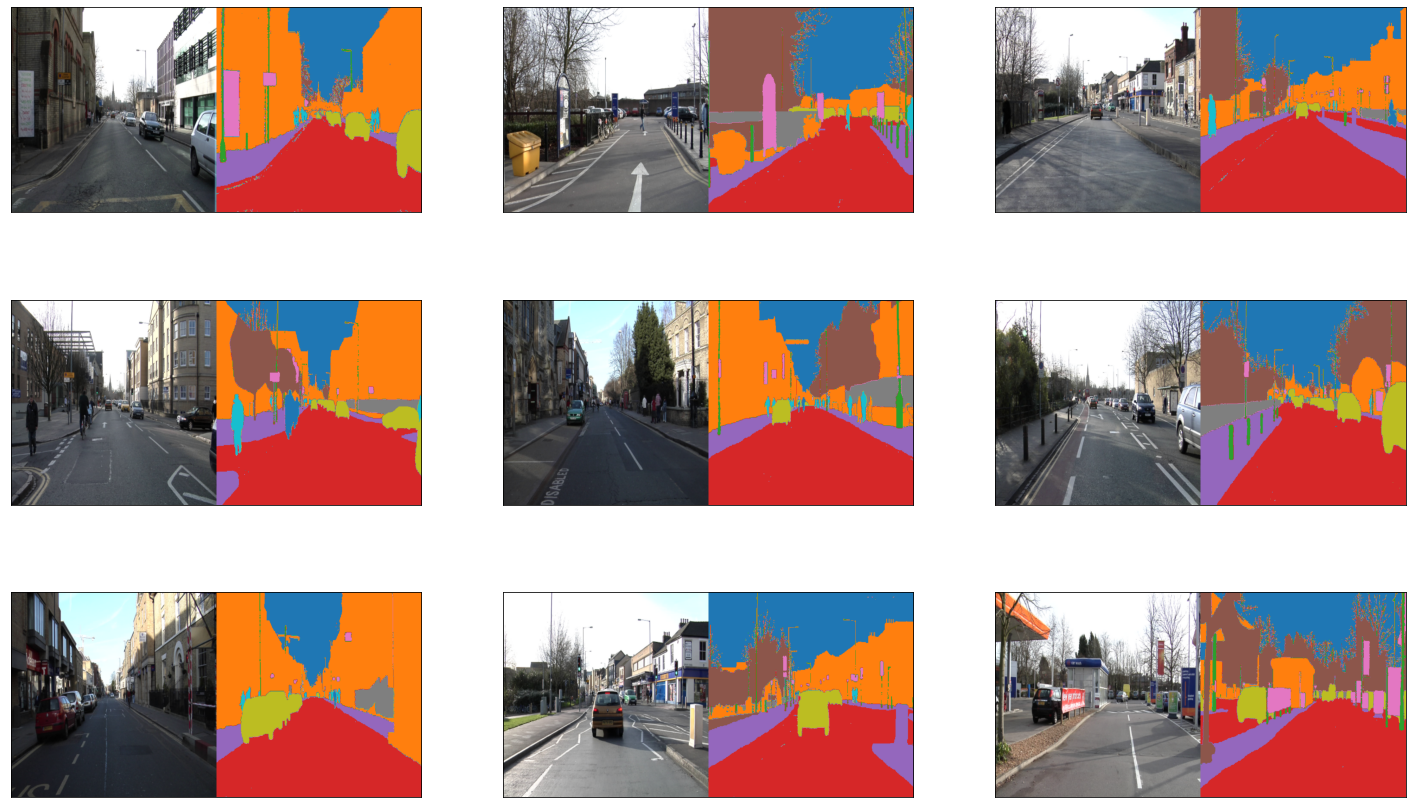

In [24]:
list_show_annotation(training_dataset)

### DeepLabv3+ with transformer
Transformer is added between encoder and decoder. The features of ASPP and lower layer from ResNet which is a feature extractor for the encoder entered into the transformer. First attention is calculated for ASPP. In second attention module, the lower layer feature act as a value and key matrix, and output from frist attention as a querry matrix. This is done to draw low semantic information from less convoluted layer.

In [44]:
#with transformer model (Q=low level out) 
#Here low level feature are Q and upsample ASPP out will be V and K  
#ASPP_uP_out and low level feature will be concanated
import os
from tensorflow.keras.layers import SeparableConv2D,AveragePooling2D,Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,UpSampling2D,Reshape,Dense,Concatenate,Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50


patch_size=4
projection_dim = 1024
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
image_size=512
mlp_head_units = [2048, 1024]
class PatchEncoder( tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        '''
        Adding positional embedding into the linear projected token
        Args:
            num_patches - token number
            projection_dim - projection dimension of token
        '''
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding =  tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def mlp(x, hidden_units, dropout_rate):
    '''
        multilayer percepton
        Args:
            hidden_units - neuron dimension for feed forward network
    '''
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

#patch representation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
    
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

def tansformer_block(aspp_out,feature,num_patches,patch_size):
    '''
    Tranformer block
        * convert feature into patch representation
        * add linear positional embedding
        * calculate multihead self-attention for both ASPP
        * calculate multihead self-attention where vk is the low level feature and q is the output from previous attention
    Args:
        aspp_out- output from ASPP module
        feature - low level feature
        num_patches - number of token
        patch_size - size of required patch
    Reuturn:
        robust multi-scale contextual information according to the correlations of every element
    '''
    patches_aspp = Patches(patch_size)(aspp_out)
    feature_out = Patches(patch_size)(feature)
    encoded_aspp = PatchEncoder(num_patches, projection_dim)(patches_aspp)
    encoded_feature = PatchEncoder(num_patches, projection_dim)(feature_out)
    
    for _ in range(transformer_layers):
        # Create a multi-head attention layer.
        attention_aspp = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.3)(encoded_aspp,encoded_aspp)
        
        attention_aspp= layers.LayerNormalization(epsilon=1e-5)(attention_aspp)
        # Skip connection 1.
        attention_aspp = layers.Add()([attention_aspp, encoded_aspp])
        # Layer normalization 2.
        attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.3
        )(attention_aspp,encoded_feature)
        f_out1= layers.Add()([attention_aspp,attention])
        
        f_out1= layers.LayerNormalization(epsilon=1e-5)(f_out1)
        # skip 2
        
        # MLP.
        f_out = mlp(f_out1, hidden_units=transformer_units, dropout_rate=0.3)
        # Skip connection 3.
        encoded_patches = layers.Add()([f_out,f_out1])
        encoded_patches= layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    return encoded_patches


def ASPP(inputs):
    '''
    To obtain information of multiscale object. Diluted convolution is used with different rate for different field of view
    Args: 
        inputs - extracted feature from ResNet
    Return:
        Multiscale feature representation
    '''
    
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)


    """ 1x1 conv """
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = SeparableConv2D(256, 3, padding="same", use_bias=False, dilation_rate=6,kernel_regularizer=tf.keras.regularizers.L1(0.01),)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = SeparableConv2D(256, 3, padding="same", use_bias=False, dilation_rate=12,kernel_regularizer=tf.keras.regularizers.L1(0.01),)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = SeparableConv2D(256, 3, padding="same", use_bias=False, dilation_rate=18,kernel_regularizer=tf.keras.regularizers.L1(0.01),)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False,kernel_regularizer=tf.keras.regularizers.L1(0.01),)(y)
    y = BatchNormalization()(y)
    y = Activation("relu",name='ASPP_out')(y)
    
    return y


def deeplabv3_plus_low_out(shape,num_patches=1024):
    '''
    deeplabv3+ framework which is encoder decoder model for semantic segmentation. Here transformer is added to improve the mask 
    prediction
    Agrs: 
        shape - input shape of the image
        num_patches - 1024 obtain based on the ASPP feature.
    Returns:
        mask prediction
    '''
    
    
    """ Input """
    inputs = Input(shape)

    """ Encoder """

    encoder = ResNet50(weights="imagenet", include_top=False,input_tensor=inputs)
    for i in encoder.layers:

      i.train_able=False

    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    image_features_2 = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(image_features_2)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    #transformer
    tr=tansformer_block(x_b,x_a,num_patches,patch_size)
    tr_layer=tf.keras.layers.Reshape((128,128,64))(tr)
    x = Concatenate()([tr_layer, x_a])

    x = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x = Conv2D(12, 1)(x)
    x = Activation("softmax")(x)

    model = Model(inputs, x)
    return model

In [45]:
model=deeplabv3_plus_low_out((image_size,image_size,3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [46]:
train_count = 367
validation_count = 101
epochs = 20
learning_rate_fn=0.01
def PolynomialDecay(epoch,iniAlpha=0.01,maxEpochs=100,power=0.9):
  decay=np.float((1 - (epoch / float(maxEpochs))) ** power)
  lr=iniAlpha*decay
  return lr

callback = tf.keras.callbacks.LearningRateScheduler(PolynomialDecay)
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/20
91/91 [==============================] - 269s 2s/step - loss: 33.7486 - accuracy: 0.7337 - val_loss: 3.6964 - val_accuracy: 0.2532
Epoch 2/20
91/91 [==============================] - 227s 2s/step - loss: 1.8660 - accuracy: 0.8204 - val_loss: 4.4882 - val_accuracy: 0.0914
Epoch 3/20
91/91 [==============================] - 225s 2s/step - loss: 1.4650 - accuracy: 0.8487 - val_loss: 2.7909 - val_accuracy: 0.3179
Epoch 4/20
91/91 [==============================] - 223s 2s/step - loss: 1.2671 - accuracy: 0.8651 - val_loss: 2.7609 - val_accuracy: 0.2928
Epoch 5/20
91/91 [==============================] - 223s 2s/step - loss: 1.1303 - accuracy: 0.8760 - val_loss: 3.1632 - val_accuracy: 0.2657
Epoch 6/20
91/91 [==============================] - 223s 2s/step - loss: 1.1890 - accuracy: 0.8805 - val_loss: 2.9028 - val_accuracy: 0.3478
Epoch 7/20
91/91 [==============================] - 223s 2s/step - loss: 1.3538 - accuracy: 0.8880 - val_loss: 2.4076 - val_accuracy: 0.4059
Epoch 8/20
9

In [ ]:
def get_images_and_segments_test_arrays():
  '''
  Gets a subsample of the val set as your test set

  Returns:
    Test set containing ground truth images and label maps
  '''
  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [ ]:

# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

In [ ]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

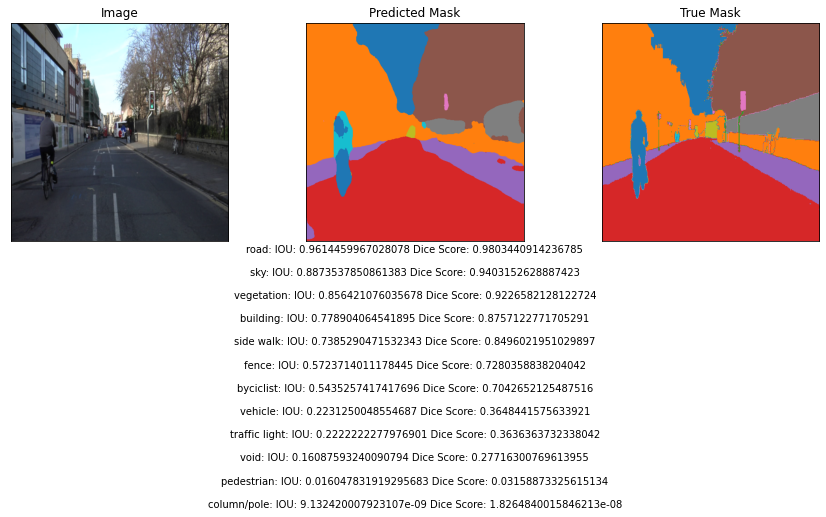

In [ ]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 0

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)